In [1]:
%matplotlib inline
import h5py
import numpy as np
import pylab as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (2,15)
pd.set_option("display.max_rows", 8)



In [2]:
#filename = '../scripts/72_2_classify.h5'
filename = '72_2_df2.h5'
class_names = {}
with h5py.File(filename, 'r') as f:
        classified_image = f['classified_image'][:]
        for name in f['classes'].attrs:
            class_names[name] = f['classes'].attrs[name]
class_names

nh, nw = classified_image.shape

pixel_length = (699.02 - 698.41)/nh * 1000
pixel_area = pixel_length * pixel_length


In [3]:
# clast_colors = ['#7E0308', '#FFFFFF','#020C7E','#020C7E',
#                 '#2CFFFE','#0F7F12', '#808080',  '#B3B3B3',
#                 '#808080', '#EEEEEE', '#FFFFFF', '#0E0E0E']

auriol_color_map = {
 u'impact-dark': '#4D4D4D',
 u'impact-medium': '#808080',
 u'impact-light': '#B3B3B3',
 u'red-siltstone': '#807F17',
 u'carbonate-white': '#2CFFFE',
 u'carbonate-tan': '#0B24FB',
 u'carbonate-brown': '#020C7E',
 u'chert': '#0F7F12',
 u'basement-mafic': '#7E0308',
 u'basement-felsic': '#FC0D1B',
 u'matrix-thermal': '#FA003F',
 u'matrix-primary': '#FC6621',
 u'void-space': '#0E0E0E',
 u'liner': '#FFFFFF'
}

clast_labels = ['Impact-Dark', 'Impact-Medium', 'Impact-Light',
                'RedSiltstone', 'Carb-White', 'Carb-Tan',
                'Carb-Brown','Chert', 'Basement-Mafic',
                'Basement-Felsic', 'Matrix-HTherm', 'Matrix-Primary',
                'Void', 'Liner']

import matplotlib.colors as colors

clast_colors = ['#4D4D4D', '#808080', '#B3B3B3', '#807F17', '#2CFFFE', '#0B24FB', '#020C7E', '#0F7F12', '#7E0308', '#FC0D1B', '#FA003F', '#FC6621', '#0E0E0E', '#FFFFFF']
cmap_clasts = colors.ListedColormap(clast_colors, 'indexed')

# clast_colors = ['#0F7F12', '#FC6621', '#807F17', '#0B24FB', '#808080', '#0E0E0E', '#4D4D4D', '#020C7E', '#2CFFFE', '#B3B3B3', '#FC0D1B',  '#7E0308']
# clast_labels = [key for key, value in sorted(class_names.iteritems(), key=lambda (k,v): (v,k))]

clast_color_map = {}
for index, key in enumerate(clast_labels):
    clast_color_map[key] = clast_colors[index]

# clast_color_map

In [4]:
clast_colors

['#4D4D4D',
 '#808080',
 '#B3B3B3',
 '#807F17',
 '#2CFFFE',
 '#0B24FB',
 '#020C7E',
 '#0F7F12',
 '#7E0308',
 '#FC0D1B',
 '#FA003F',
 '#FC6621',
 '#0E0E0E',
 '#FFFFFF']

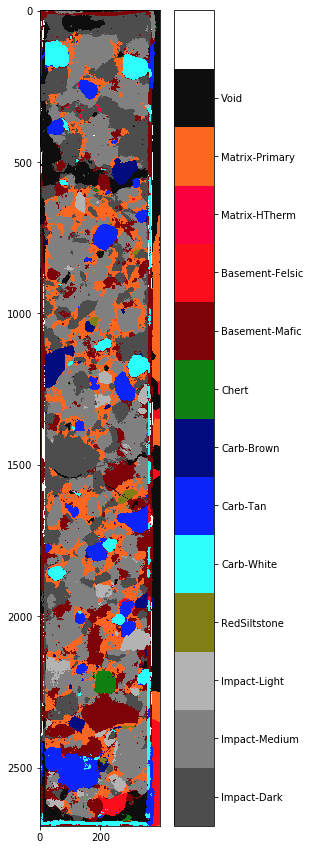

In [5]:
import matplotlib.colors as colors
from skimage import data as skdata

nclasses = len(clast_colors)
#cmap_clasts = colors.ListedColormap(clast_colors[0:len(clast_colors)], 'indexed')

fig, ax = plt.subplots(figsize=(5,15))
cax = ax.imshow(classified_image+1, cmap=cmap_clasts, clim=(0.5,  nclasses + 0.5))
cbar = fig.colorbar(cax, ticks=range(nclasses))
cbar.ax.set_yticklabels(clast_labels)

#fig.savefig('labeled_image.png', dpi=300,bbox_inches='tight', transparent=True)

photo_img = skdata.imread("/Users/bhall/Projects/Chicxulub/suevite_clasts/data/72_2/364_77_A_072_R_002_scanA67_Clasts.png")
# plt.imshow(img)



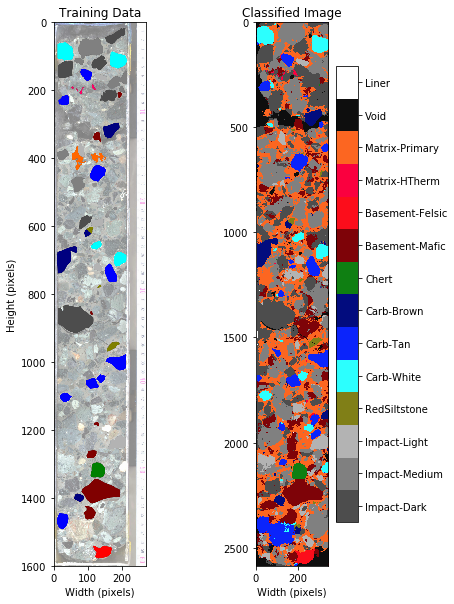

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,10))



cax = ax2.imshow(classified_image+1, cmap=cmap_clasts, clim=(0.5,  nclasses + 0.5))
cbar = fig.colorbar(cax, ticks=range(nclasses+1))
cbar.ax.set_yticklabels(clast_labels)

pax = ax1.imshow(photo_img)
ax1.set_title('Training Data')
ax2.set_title('Classified Image')
ax1.set_ylabel('Height (pixels)')
ax2.set_xlabel('Width (pixels)')
ax1.set_xlabel('Width (pixels)')
fig.savefig('classified_image_training.png', dpi=300,bbox_inches='tight', transparent=True)

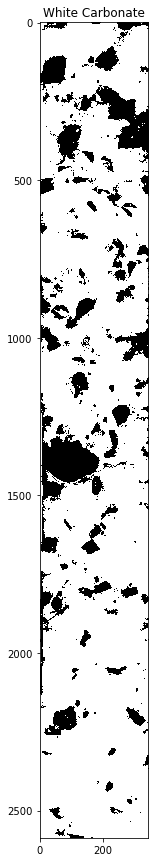

In [56]:
carbonate_image = classified_image == 0
fig=plt.figure(figsize=(2,15))
plt.imshow(carbonate_image, cmap='Greys')
plt.title('White Carbonate')
fig.savefig('white_carbonate.png', dpi=300,bbox_inches='tight', transparent=True)

(2587, 344)

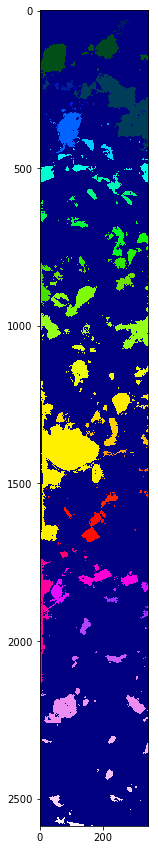

In [57]:
from skimage.measure import label, regionprops

label_image = label(carbonate_image)
plt.imshow(label_image, cmap='gist_ncar')
label_image.shape

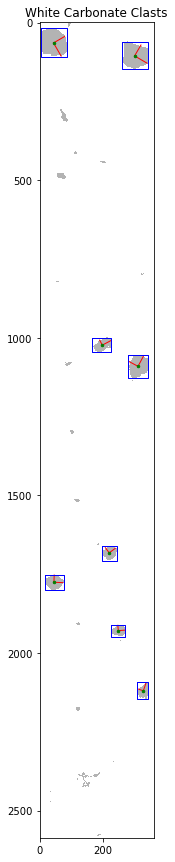

In [32]:
fig, ax = plt.subplots(figsize=(4,15))
ax.imshow(~carbonate_image, cmap=plt.cm.gray, interpolation='none', alpha=0.3)
plt.title('White Carbonate Clasts')
# plt.xlim((0,910))
# plt.ylim((749,0))
import math

aspect_ratios = []
areas = []
pos_y = []
regions = regionprops(label_image)
perimeters = []
for region in regions:
        if region.area <= 1000:
            continue
        y0, x0 = region.centroid
        orientation = region.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * region.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.minor_axis_length

        if region.minor_axis_length != 0:
            aspect_ratio = region.major_axis_length / region.minor_axis_length
            aspect_ratios.append(aspect_ratio)
        
        areas.append(region.area * pixel_area)
        pos_y.append(y0)
        perimeters.append(region.perimeter * pixel_length)
        
        ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
        ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)
        ax.plot(x0, y0, '.g', markersize=5)

        minr, minc, maxr, maxc = region.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=1)
fig.savefig('white_carbonate_shapes.png', dpi=300,bbox_inches='tight', transparent=True)

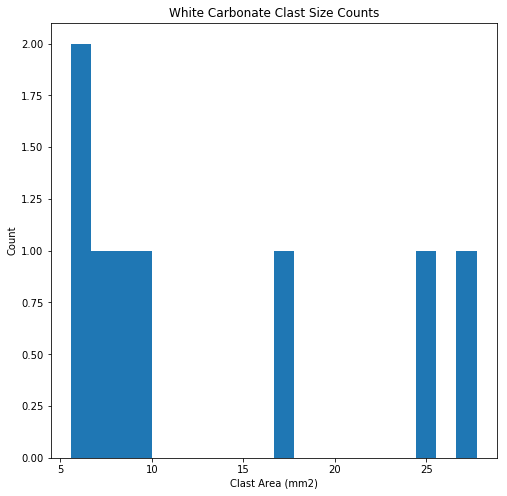

In [33]:
fig = plt.figure(figsize=(8,8))
n, bins, patches = plt.hist(areas, 20)
plt.title('White Carbonate Clast Size Counts')
plt.xlabel('Clast Area (mm2)')
plt.ylabel('Count')

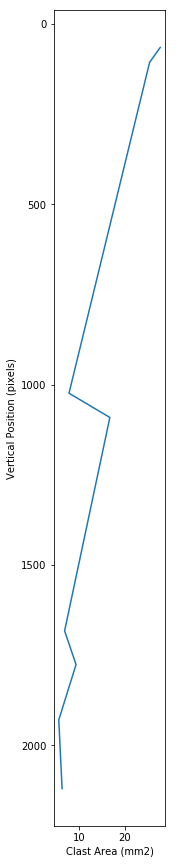

In [34]:
plt.plot(areas, pos_y)
plt.gca().invert_yaxis()
plt.xlabel('Clast Area (mm2)')
plt.ylabel('Vertical Position (pixels)')

In [35]:
df = pd.Series(areas, index=pos_y)


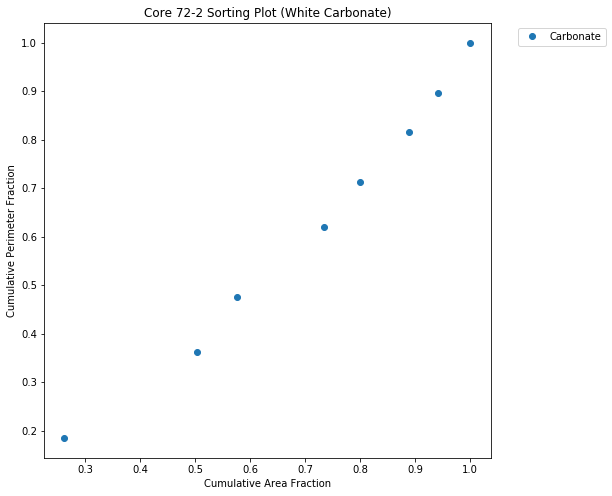

In [36]:
cum_perimeters = np.cumsum(perimeters)
total_perimeters = np.float(np.sum(perimeters))
cum_areas = np.cumsum(areas)
total_areas = np.float(np.sum(areas))

fig = plt.figure(figsize=(8,8))
plt.plot(cum_areas/total_areas, cum_perimeters/total_perimeters, 'o', label='Carbonate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Cumulative Area Fraction')
plt.ylabel('Cumulative Perimeter Fraction')
plt.title('Core 72-2 Sorting Plot (White Carbonate)')
cum_areas
fig.savefig('72_2_all_white_carbonate.png', dpi=300, transparent=True)

In [41]:
from collections import defaultdict

def get_class_stats(classified_img, class_id):
    
    # isolate the class of interest
    class_image = classified_img == class_id
    
    # label the unique regions
    label_image = label(class_image)
    
    class_stats = defaultdict(list)
    
    #aspect_ratios = []
#     areas = []
#     pos_y = []
#     perimeters = []
    
    regions = regionprops(label_image)

    for region in regions:
            if region.area <= 1000:
                continue
            y0, x0 = region.centroid
            orientation = region.orientation

            if region.minor_axis_length != 0:
                aspect_ratio = region.major_axis_length / region.minor_axis_length
                class_stats['aspect_ratios'].append(aspect_ratio)

            class_stats['areas'].append(region.area)
            class_stats['pos_y'].append(y0)
            class_stats['perimeters'].append(region.perimeter)
    
    class_stats['cum_perimeters'] = np.cumsum(perimeters)
    # total_perimeters = np.float(np.sum(perimeters))
    class_stats['cum_areas'] = np.cumsum(areas)
    # total_areas = np.float(np.sum(areas))
    
    return class_stats

In [42]:
carb_stats = get_class_stats(classified_image, 4)

In [44]:
class_names

{'Basement-Felsic': 10,
 'Basement-Mafic': 9,
 'Carb-Brown': 7,
 'Carb-Tan': 6,
 'Carb-White': 5,
 'Chert': 8,
 'Impact-Dark': 1,
 'Impact-Light': 3,
 'Impact-Medium': 2,
 'Liner': 14,
 'Matrix-HTherm': 11,
 'Matrix-Primary': 12,
 'RedSiltstone': 4,
 'Void': 13}

In [45]:
valid_clasts = [u'Basement-Felsic', u'Basement-Mafic', u'Carb-Brown', u'Carb-Tan',
                u'Carb-White', u'Chert', u'Impact-Dark', u'Impact-Light', u'Impact-Medium',
                u'RedSiltstone']
#valid_clasts = ['carbonate-white']

clast_stats = {}
for clast_type in valid_clasts:
    clast_index = class_names[clast_type]
    clast_stats[clast_type] = get_class_stats(classified_image, clast_index)
    #clast_stats[clast_type] = carb_stats(classified_image, clast_index)

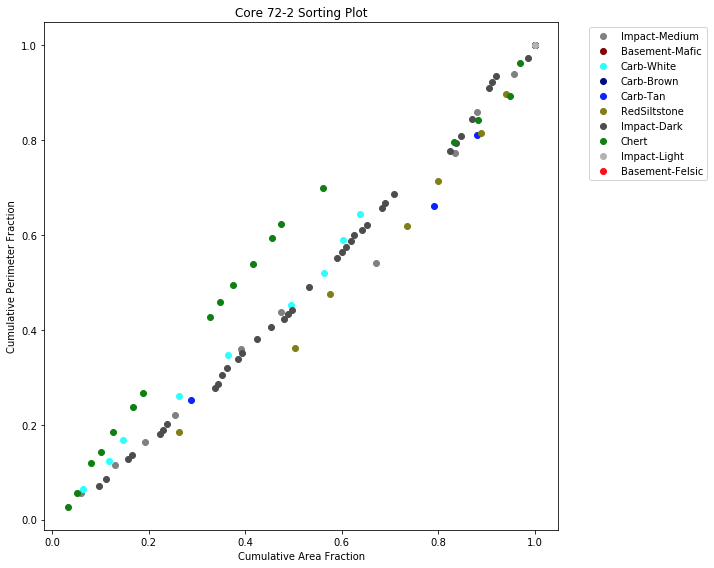

In [48]:
fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for clast_type in clast_stats:
    
    cum_areas = np.cumsum(clast_stats[clast_type]['areas'])
    total_area = np.float(np.sum(clast_stats[clast_type]['areas']))
    cum_perimeters = np.cumsum(clast_stats[clast_type]['perimeters'])
    total_perimeter = np.float(np.sum(clast_stats[clast_type]['perimeters']))
    ax.plot(cum_areas/total_area, cum_perimeters/total_perimeter, 'o', label=clast_type, color=clast_color_map[clast_type])
    
    
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Cumulative Area Fraction')
plt.ylabel('Cumulative Perimeter Fraction')
plt.title('Core 72-2 Sorting Plot')
plt.tight_layout()
fig.savefig('72_2_all_sorting.png', dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)

(93,)

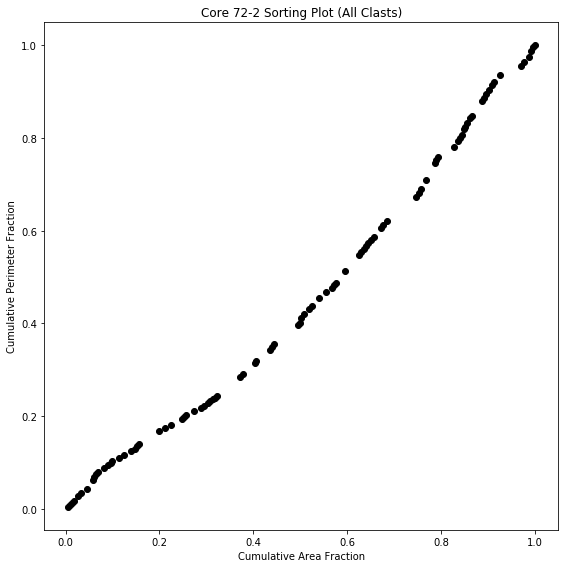

In [49]:
fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

all_areas = np.array([])
all_perims = np.array([])

for clast_type in clast_stats:
    
    all_areas = np.concatenate((all_areas, clast_stats[clast_type]['areas']), axis=0)
    all_perims = np.concatenate((all_perims, clast_stats[clast_type]['perimeters']), axis=0)
    
cum_areas = np.cumsum(all_areas)
total_area = np.float(np.sum(all_areas))
cum_perimeters = np.cumsum(all_perims)
total_perimeter = np.float(np.sum(all_perims))
ax.plot(cum_areas/total_area, cum_perimeters/total_perimeter, 'o', color='k')
    
    
#lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Cumulative Area Fraction')
plt.ylabel('Cumulative Perimeter Fraction')
plt.title('Core 72-2 Sorting Plot (All Clasts)')
plt.tight_layout()
fig.savefig('72_2_combined_clast_sorting.png', dpi=300,transparent=True)
all_areas.shape

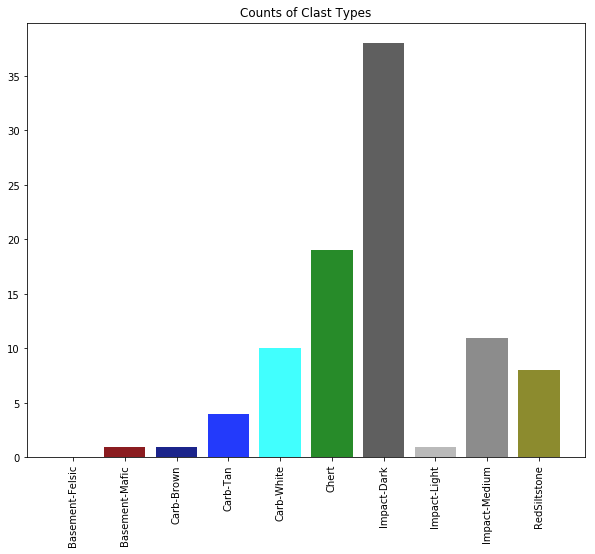

In [50]:
# histogram of each clast type (or bar chart)
clast_numbers = []
valid_clast_colors = []
for clast_type in valid_clasts:
    clast_numbers.append(len(clast_stats[clast_type]['aspect_ratios']))
    valid_clast_colors.append(clast_color_map[clast_type])
#clast_numbers = [len(clast_stats[clast_type]['aspect_ratios']) for clast_type in clast_stats]
#clast_labels = [clast_type for clast_type in clast_stats]
xpos = np.arange(len(valid_clasts))
fig = plt.figure(figsize=(10,8))
plt.bar(xpos, clast_numbers, align='center',alpha=0.9, color=valid_clast_colors)
plt.xticks(xpos, valid_clasts, rotation=90)
plt.title('Counts of Clast Types')
fig.savefig('ClastCounts.png', dpi=100, transparent=True, bbox_inches='tight')

In [51]:
# angularity - use aspect ratio?
clast_labels

['Impact-Dark',
 'Impact-Medium',
 'Impact-Light',
 'RedSiltstone',
 'Carb-White',
 'Carb-Tan',
 'Carb-Brown',
 'Chert',
 'Basement-Mafic',
 'Basement-Felsic',
 'Matrix-HTherm',
 'Matrix-Primary',
 'Void',
 'Liner']

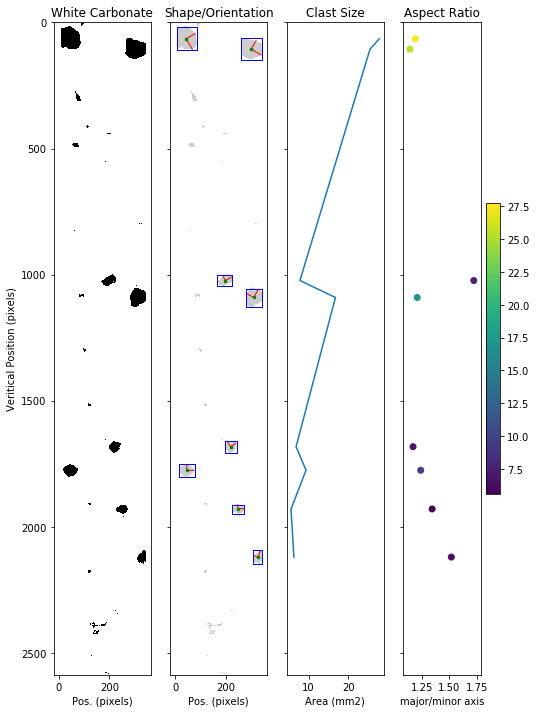

In [54]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(8,12))

ax1.imshow(carbonate_image, cmap='Greys')
ax1.set_title('White Carbonate')

# shape plot
ax2.imshow(~carbonate_image, cmap=plt.cm.gray, interpolation='none', alpha=0.2)
#plt.title('White Carbonate Clasts')
ax2.set_xlim((0,344))
ax2.set_ylim((2587,0))
import math

for region in regions:
        if region.area <= 1000:
            continue
        y0, x0 = region.centroid
        orientation = region.orientation
        x1 = x0 + math.cos(orientation) * 0.5 * region.major_axis_length
        y1 = y0 - math.sin(orientation) * 0.5 * region.major_axis_length
        x2 = x0 - math.sin(orientation) * 0.5 * region.minor_axis_length
        y2 = y0 - math.cos(orientation) * 0.5 * region.minor_axis_length
        
        ax2.plot((x0, x1), (y0, y1), '-r', linewidth=1)
        ax2.plot((x0, x2), (y0, y2), '-r', linewidth=1)
        ax2.plot(x0, y0, '.g', markersize=5)

        minr, minc, maxr, maxc = region.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax2.plot(bx, by, '-b', linewidth=1)
        
ax2.set_title('Shape/Orientation')

ax3.plot(areas, pos_y)
#ax3.invert_yaxis()
ax3.set_title('Clast Size')
ax3.set_xlabel('Area (mm2)')
ax1.set_ylabel('Veritical Position (pixels)')
ax1.set_xlabel('Pos. (pixels)')
ax2.set_xlabel('Pos. (pixels)')

splot = ax4.scatter(aspect_ratios, pos_y, c=areas)
cbar = fig.colorbar(splot, ax=ax4)
ax4.set_title('Aspect Ratio')
ax4.set_xlabel('major/minor axis')
fig.savefig('shape_analysis.png', dpi=300,bbox_inches='tight', transparent=True)

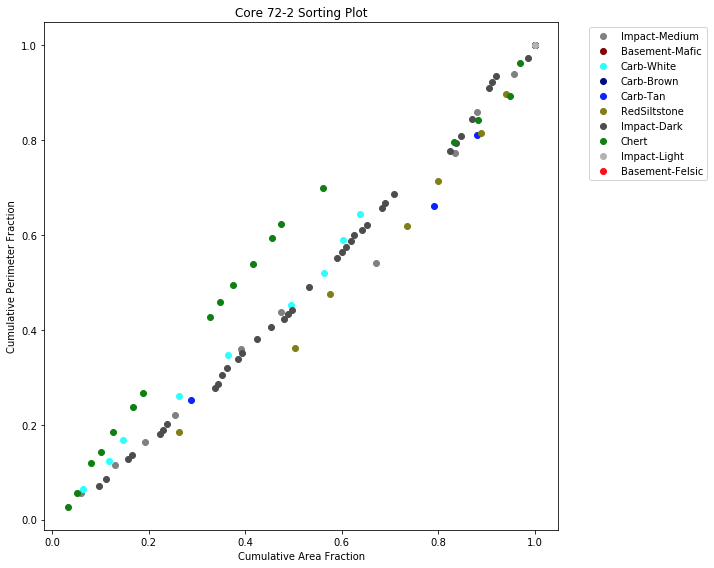

In [55]:
fig= plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

for clast_type in clast_stats:
    
    cum_areas = np.cumsum(clast_stats[clast_type]['areas'])
    total_area = np.float(np.sum(clast_stats[clast_type]['areas']))
    cum_perimeters = np.cumsum(clast_stats[clast_type]['perimeters'])
    total_perimeter = np.float(np.sum(clast_stats[clast_type]['perimeters']))
    ax.plot(cum_areas/total_area, cum_perimeters/total_perimeter, 'o', label=clast_type, color=clast_color_map[clast_type])
    
    
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.xlabel('Cumulative Area Fraction')
plt.ylabel('Cumulative Perimeter Fraction')
plt.title('Core 72-2 Sorting Plot')
plt.tight_layout()
fig.savefig('72_2_all_sorting.png', dpi=300,bbox_extra_artists=(lgd,), bbox_inches='tight', transparent=True)

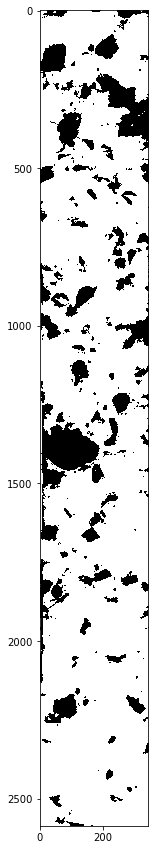

In [74]:
from skimage.morphology import opening, closing

clast_image = classified_image == 0
opened_image = closing(closing(clast_image))
opened_image = opening(opening(opened_image))
fig = plt.figure(figsize=(2,15))
plt.imshow(opened_image, cmap='Greys')
fig.savefig('pigeonite_grains.png', dpi=300)

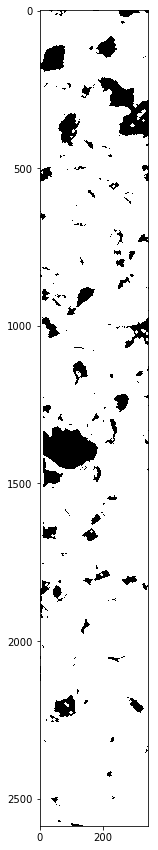

In [83]:
from skimage.morphology import opening, erosion, dilation
#apply the erosion operation twice
erosion_image = clast_image
erosion_image = erosion(erosion(erosion(erosion(erosion_image))))
#erosion_image = opening(opening(opening(opening(erosion_image))))
plt.figure(figsize=(2,15))
plt.imshow(erosion_image, cmap='Greys', interpolation='None')

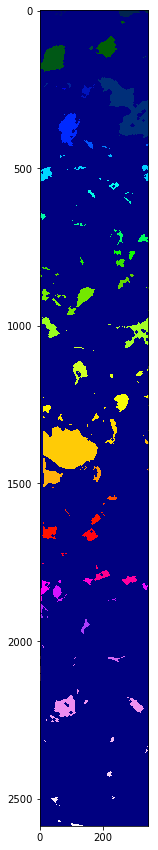

In [84]:
relabel_image = label(erosion_image)
plt.figure(figsize=(2,15))
plt.imshow(relabel_image,cmap='gist_ncar', interpolation='None')

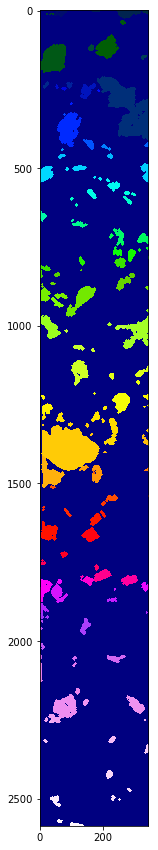

In [85]:
#relabel_image = opening(relabel_image)
relabel_image = dilation(dilation(dilation(dilation(relabel_image))))
fig = plt.figure(figsize=(2,15))
plt.imshow(relabel_image,cmap='gist_ncar', interpolation='None')
#fig.savefig('analysis_images/labeled_image.png', dpi=300)

In [122]:
regions = regionprops(relabel_image)

core_top_depth = 0.
clast_type = clast_labels[0]
area_cutoff = 40.
height, width = relabel_image.shape
for region in regions:
        area_mm2 = region.area * pixel_area
    
        if area_mm2 <= area_cutoff:
            continue
            
        y0, x0 = region.centroid
        orientation = region.orientation

        if region.minor_axis_length != 0:
            aspect_ratio = region.major_axis_length / region.minor_axis_length       
       
        perimeter = region.perimeter * pixel_length
        depth = core_top_depth + y0*pixel_length
        dist_from_center = np.abs((width/2) - x0) * pixel_length
        
        clast_list.append({'Type': clast_type, 'Area': area_mm2, 
                           'MajorAxis': region.major_axis_length*pixel_length,
                           'MinorAxis': region.minor_axis_length*pixel_length,
                           'Angle': region.orientation,
                           'Depth': depth,
                           'DistFromCenter' : xpos, 
                           'Perimeter': perimeter})

clast_df = pd.DataFrame(clast_list)
#fig.savefig('white_carbonate_shapes.png', dpi=300,bbox_inches='tight', transparent=True)

In [123]:
clast_df

,Angle,Area,Depth,DistFromCenter,MajorAxis,MinorAxis,Perimeter,Type
0,0.080945,78.283362,2.309378,30.609209,18.286703,6.076725,44.887590,Impact-Dark
1,0.778038,194.096034,27.965373,30.609209,18.073241,14.247689,64.005374,Impact-Dark
2,0.943374,327.533582,36.287355,30.609209,24.316592,17.653654,81.410826,Impact-Dark
3,-0.992294,906.986136,73.316449,30.609209,57.520712,25.849410,247.253281,Impact-Dark
...,...,...,...,...,...,...,...,...
68,1.211416,53.875410,460.646541,30.609209,13.396773,6.054315,35.937220,Impact-Dark
69,0.032733,47.926319,484.639739,30.609209,14.580911,5.445882,39.433680,Impact-Dark
70,0.442058,232.904121,520.908685,30.609209,18.676615,16.637734,78.503257,Impact-Dark
71,-0.777096,95.519045,519.338031,30.609209,17.000208,7.446304,46.527143,Impact-Dark


In [146]:
clast_list = []
for clast_type in valid_clasts:
    
    clast_index = clast_labels.index(clast_type)
    print(clast_index)
    clast_image = classified_image == clast_index
    opened_image = closing(closing(clast_image))
    opened_image = opening(opening(opened_image))
    
    from skimage.morphology import opening, erosion, dilation
    #apply the erosion operation twice
    erosion_image = clast_image
    erosion_image = erosion(erosion(erosion(erosion(erosion_image))))
    
    relabel_image = label(erosion_image)
    
    relabel_image = dilation(dilation(dilation(dilation(relabel_image))))
    
    
    regions = regionprops(relabel_image)
    print('there are {} {} clasts.'.format(len(regions), clast_type))
    core_top_depth = 0.
    
    area_cutoff = 40.
    height, width = relabel_image.shape
    for region in regions:
            area_mm2 = region.area * pixel_area

            if area_mm2 <= area_cutoff:
                continue

            y0, x0 = region.centroid
            orientation = region.orientation

            if region.minor_axis_length != 0:
                aspect_ratio = region.major_axis_length / region.minor_axis_length       

            perimeter = region.perimeter * pixel_length
            depth = (core_top_depth + y0*pixel_length) / 1000
            dist_from_center = np.abs((width/2) - x0) * pixel_length

            clast_list.append({'Type': clast_type, 'Area': area_mm2, 
                               'MajorAxis': region.major_axis_length*pixel_length,
                               'MinorAxis': region.minor_axis_length*pixel_length,
                               'Angle': region.orientation,
                               'Depth': depth,
                               'DistFromCenter' : dist_from_center, 
                               'Perimeter': perimeter})


clast_df = pd.DataFrame(clast_list)

9
there are 2 Basement-Felsic clasts.
8
there are 125 Basement-Mafic clasts.
6
there are 12 Carb-Brown clasts.
5
there are 23 Carb-Tan clasts.
4
there are 17 Carb-White clasts.
7
there are 1 Chert clasts.
0
there are 192 Impact-Dark clasts.
2
there are 56 Impact-Light clasts.
1
there are 189 Impact-Medium clasts.
3
there are 9 RedSiltstone clasts.


In [147]:
clast_df

,Angle,Area,Depth,DistFromCenter,MajorAxis,MinorAxis,Perimeter,Type
0,0.420228,254.587723,0.599559,13.834779,23.358657,15.427665,80.615590,Basement-Felsic
1,-1.239275,93.072690,0.114408,6.781834,13.086715,9.467641,44.557001,Basement-Mafic
2,-0.048038,48.593507,0.121206,27.150344,9.505079,7.358444,32.717011,Basement-Mafic
3,-0.839084,61.270074,0.186149,33.153500,9.451433,8.575024,33.636490,Basement-Mafic
...,...,...,...,...,...,...,...,...
134,-1.498039,643.168983,0.560686,27.776424,36.593603,24.496729,173.173151,Impact-Medium
135,0.807090,41.754833,0.586680,36.913905,8.234872,6.554835,24.542246,Impact-Medium
136,-0.901979,86.790005,0.603123,13.161887,12.148916,9.795648,47.379592,Impact-Medium
137,0.175162,58.323328,0.357125,26.653978,11.543462,6.768660,33.050475,RedSiltstone


In [140]:
clast_labels.index('Basement-Mafic')

8